In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!cp -r /content/drive/MyDrive/train_with.csv ./
!cp -r /content/drive/MyDrive/eval_with.csv ./

In [ ]:
import pandas as pd

df_train_with_period_id = pd.read_csv('train_with.csv')
df_eval_with_period_id = pd.read_csv('eval_with.csv')

In [ ]:
df_train_with_period_id['Tweet_list'] = df_train_with_period_id['Tweet'].apply(eval).apply(lambda x: x[:32])

In [ ]:
df_train_with_period_id.columns

Index(['Unnamed: 0', 'EventType', 'Tweet', 'Tweet_list'], dtype='object')

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)

In [ ]:
from transformers import BertTokenizer, BertModel

model = BertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
initial_embeds = model.embeddings.word_embeddings.weight

In [ ]:
reduced_embeddings = pca.fit_transform(initial_embeds.detach().numpy())

In [ ]:
import torch.nn as nn
import torch

reduced_embeddings_layer = nn.Embedding.from_pretrained(torch.tensor(reduced_embeddings))

In [ ]:
reduced_embeddings_layer.to("cuda")

Embedding(30522, 64)

In [ ]:
import torch

input_ids = torch.tensor(df_train_with_period_id['Tweet_list'], device='cuda', dtype=torch.int32)

In [ ]:
from sklearn.model_selection import train_test_split

y = df_train_with_period_id['EventType'].to_list()
input_ids_little, input_ids_rest, y_little, y_rest = train_test_split(input_ids, y, test_size=0.95)

In [ ]:
input_ids_little.shape, input_ids_rest.shape

(torch.Size([252802, 32]), torch.Size([4803248, 32]))

In [ ]:
with torch.no_grad():
    X_embeddings = reduced_embeddings_layer(input_ids_little)

In [ ]:
X_embeddings_cpu = X_embeddings.cpu()

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_embeddings_cpu, y_little, test_size=0.1)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


boosting_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=50
)

In [ ]:
B, L, C = X_train.shape
X_train = X_train.view(B, -1)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
boosting_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:56:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
B_, L_, C_ = X_test.shape
X_test = X_test.view(B_, -1)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
final_accuracy = accuracy_score(y_test, boosting_model.predict(X_test))
print("Final Accuracy:", final_accuracy)

Final Accuracy: 0.685059926426961


In [ ]:
plt.plot(range(epochs), train_loss, label='Training Loss')

In [ ]:
df_eval_with_period_id['Tweet_list'] = df_eval_with_period_id['Tweet'].apply(eval).apply(lambda x: x[:32])

In [ ]:
import torch

input_eval_ids = torch.tensor(df_eval_with_period_id['Tweet_list'], device='cuda', dtype=torch.int32)

In [ ]:
input_eval_ids.shape

torch.Size([1072928, 32])

In [ ]:
from sklearn.model_selection import train_test_split

y = df_train_with_period_id['EventType'].to_list()
input_ids_little, input_ids_rest, y_little, y_rest = train_test_split(input_ids, y, test_size=0.95)

In [ ]:
input_ids_little.shape, input_ids_rest.shape

(torch.Size([252802, 32]), torch.Size([4803248, 32]))

In [ ]:
with torch.no_grad():
    X_embeddings = reduced_embeddings_layer(input_eval_ids)

In [ ]:
X_embeddings = X_embeddings.view(X_embeddings.shape[0], -1)

In [ ]:
df_eval_with_period_id['EventType'] = boosting_model.predict(X_embeddings.cpu())

In [ ]:
df_avg = df_eval_with_period_id.groupby('ID')['EventType'].mean().round().astype(int).reset_index()

In [ ]:
df_avg

,ID,EventType
0,15_0,0
1,15_1,0
2,15_10,1
3,15_100,1
4,15_101,1
...,...,...
511,9_95,0
512,9_96,1
513,9_97,1
514,9_98,1


(array([197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 319.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

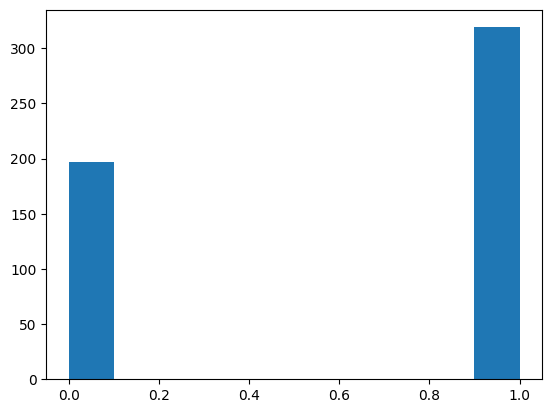

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df_avg['EventType'])

In [ ]:
df_avg.to_csv('data_full_round_simple_embeds.csv', index=False)